# Predicting house prices

This script uses the daft.ie ad data enriched by openstreetmap data to predict house prices. 

## Describing and cleaning the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

df_ads = pd.read_pickle('df_ads_mapdata.pkl')
df_ads.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13766 entries, 0 to 13765
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               13766 non-null  object 
 1   ad_ids              13766 non-null  object 
 2   advertising_type    3510 non-null   object 
 3   area                13766 non-null  object 
 4   bathrooms           13685 non-null  float64
 5   beds                13685 non-null  float64
 6   ber_classification  10549 non-null  object 
 7   caferestaurants     13766 non-null  int64  
 8   churches            13766 non-null  int64  
 9   county              13766 non-null  object 
 10  currency            13685 non-null  object 
 11  dist_to_centre      13766 non-null  float64
 12  environment         13766 non-null  object 
 13  facility            13685 non-null  object 
 14  health              13766 non-null  int64  
 15  latitude            13766 non-null  float64
 16  long

In [2]:
df_ads['published_date'] = pd.to_datetime(df_ads.published_date)
df_ads['month'] = df_ads['published_date'].dt.to_period('M').astype(str)

df_ads['parking'] = df_ads.facility.str.contains('parking', case=False, regex=False)


Selecting the relevant variables and describing

In [3]:
df_ads = df_ads[['price','surface','area','property_type','ber_classification','seller_type','selling_type','price_type','month','bathrooms','beds','dist_to_centre','caferestaurants', 'churches', 'health', 'parks', 'platforms', 'pubs','schools', 'shops', 'sports', 'stations', 'latitude', 'longitude','parking']]

df_ads.describe()


,price,surface,bathrooms,beds,dist_to_centre,caferestaurants,churches,health,parks,platforms,pubs,schools,shops,sports,stations,latitude,longitude
count,1.358700e+04,11445.000000,13685.000000,13685.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000,13766.000000
mean,4.608695e+05,332.236147,1.900256,2.863500,12.591567,6.606204,1.179428,0.202528,2.711318,11.604823,3.249673,1.372512,18.438544,5.175432,0.746840,53.334589,-6.259834
std,4.023205e+05,12562.974017,1.144067,1.267411,222.311229,21.324450,1.857644,0.590846,3.310769,10.339013,9.027040,1.416415,37.563044,5.272972,1.732884,1.118720,2.198103
min,3.000000e+04,0.500000,0.000000,0.000000,0.043133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533968,-99.613000
25%,2.700000e+05,72.000000,1.000000,2.000000,3.939526,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,1.000000,0.000000,53.297818,-6.324053
50%,3.550000e+05,93.220000,2.000000,3.000000,7.368760,1.000000,1.000000,0.000000,2.000000,10.000000,1.000000,1.000000,6.000000,4.000000,0.000000,53.342057,-6.264242
75%,5.250000e+05,126.000000,2.000000,3.000000,11.293652,4.000000,1.000000,0.000000,4.000000,15.000000,3.000000,2.000000,18.000000,7.000000,0.000000,53.384138,-6.207221
max,1.000000e+07,937498.805670,29.000000,29.000000,18910.115692,317.000000,16.000000,5.000000,39.000000,136.000000,124.000000,7.000000,462.000000,38.000000,15.000000,54.609707,172.679026


Dropping some very unusual houses and plotting the distribution of the surface area. Recoding missings of price type.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


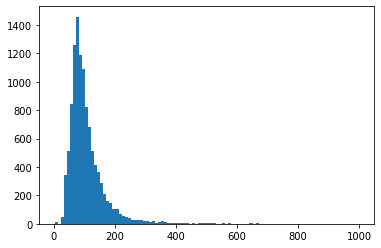

In [4]:

df_ads.loc[df_ads['price_type'] == "", 'price_type'] = "Normal"

df_ads = df_ads.drop(df_ads[df_ads.bathrooms>=8].index)
df_ads = df_ads.drop(df_ads[df_ads.beds>=10].index)
df_ads = df_ads.drop(df_ads[df_ads.property_type=='site'].index)
df_ads.loc[df_ads['surface'] > 1000, 'surface'] = np.nan
df_ads = df_ads.drop(df_ads[df_ads.dist_to_centre > 30].index)

plt.hist(df_ads.surface, bins = 100)
plt.show()

Calculating and plotting the log price per square meter

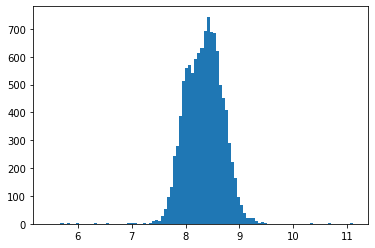

In [5]:
df_ads['price_sqm'] = np.log(df_ads.price / df_ads.surface)

plt.hist(df_ads.price_sqm, bins = 100)
plt.show()


Log transforming the price and plotting

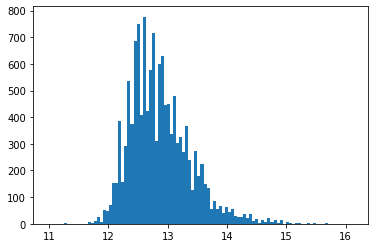

In [6]:
df_ads['price'] = np.log(df_ads.price)
plt.hist(df_ads.price, bins = 100)
plt.show()


Dropping rows with missing price

In [7]:
df_ads = df_ads.dropna(subset=['price'])
#df_ads = df_ads.dropna(subset=['price_sqm'])


Splitting data into training and testing

In [8]:
y = df_ads['price']
X = df_ads.drop(['price','price_sqm'], axis=1)
#X = df_ads.drop('surface', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Preprocessing pipeline

Creating a list of categorical features and a list of numeric features. Both sets of features will be transformed and imputed differently. The categorical features need to be encoded to binary variables.

In [9]:
categorical_features = df_ads.columns[df_ads.dtypes==object].tolist()

numeric_features = list(df_ads.columns)
for x in categorical_features:
    numeric_features.remove(x)

numeric_features.remove('price')
numeric_features.remove('price_sqm')
#numeric_features.remove('surface')


Categorical varibales are imputed with the most frequent value and dummies are created using OneHotEncoder

In [10]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


Transform numerical columns by imputing missing values using K nearest neighbours. Especially the surface area is an important feature with a relatively high degree of missingness. KNN is a flexible non-parametric method of imputation. Standardisation afterwards.

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', StandardScaler())])

The columntransformer transforms numeric features differently than the categorial features.

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Defining a function that plots the density of the house prices in the testing data and the predictions.

In [13]:
def densplot(title,text_x,text_y):
    sns.distplot(y_test, hist = False, kde = True,
                    kde_kws = {'shade': True, 'linewidth': 3}, 
                    label = "Observed")
    sns.distplot(y_pred, hist = False, kde = True,
                    kde_kws = {'shade': True, 'linewidth': 3}, 
                    label = "Predicted")     
    plt.xlabel("log(price)")
    plt.title(title)
    plt.text(text_x, text_y, "R2: {:.3f}".format(r2) + "\n" + "RMSE: {:.3f}".format(rmse), 
    horizontalalignment='right', size='medium', color='black')
    plt.tight_layout()
    plt.show() 

This function plots a scatterplot of the root squared error by each house price level. 

In [14]:
def rse_plot(title):
    df = pd.DataFrame({"y_pred": y_pred, "rse": rse})
    sns.lmplot(x="y_pred", y="rse", data=df)
    plt.xlabel("log of house price")
    plt.ylabel("Root squared error")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Fitting the models

The log of the housing price follows a quite a normal distribution. Also, many relationships can be assumed to have a linear effect, e.g. the surface area as well as any binary variables such as the neighbourhood. Coordinates are also included as features, which probably will not have a linear effect. A non-linear model such as random forest might use that better (see below)

An elasticnet is initialised and gridsearch is used to tune the parameters. 

In [15]:
        
steps_enet = [('preprocessor', preprocessor),
              ('reg', ElasticNet(max_iter=10000))]

pipeline_enet = Pipeline(steps_enet)

parametersGrid = {"reg__alpha": [0.001,0.01, 0.1,0.5,0.9,1],
                  "reg__l1_ratio": np.arange(0.1, 1, 0.1)}

grid_enet = GridSearchCV(pipeline_enet, parametersGrid, scoring='r2', cv=3, n_jobs=-1)

grid_enet.fit(X_train, y_train)

best_model = grid_enet.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tuned best parameters: {}".format(grid_enet.best_params_))
print("Tuned R squared: {:.4f}".format(r2))
print("Tuned RMSE: {:.4f}".format(rmse))

Tuned best parameters: {'reg__alpha': 0.001, 'reg__l1_ratio': 0.1}
Tuned R squared: 0.8646
Tuned RMSE: 0.1958


The low alpha and L1 ratio shows that no penalty is needed because there is little risk of overfitting and that simple linear regression is probably better. 

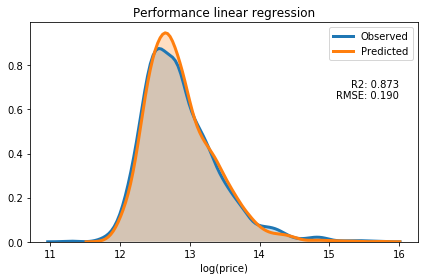

In [16]:

steps_linreg = [('preprocessor', preprocessor),
                ('linreg', LinearRegression())]

pipeline_linreg = Pipeline(steps_linreg)

params_linreg = {}
grid_linreg = GridSearchCV(estimator=pipeline_linreg,
                       param_grid=params_linreg,
                       scoring='r2',
                       cv=3,
                       n_jobs=-1)

grid_linreg.fit(X_train,y_train)

best_model = grid_linreg.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_pred,y_test))

densplot("Performance linear regression", 16, 0.65)


This shows that the R2 of the linear model performs the best and is sligthly better than elasticnet. The plot below shows no obvious pattern of the errors

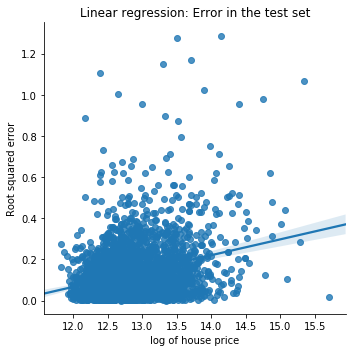

In [17]:

rse = np.sqrt((y_pred - y_test)**2)

rse_plot("Linear regression: Error in the test set")


Here a random forest estimator is initialised, following the same preprocessing steps. 

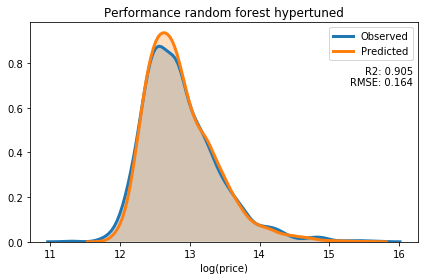

Tuned best parameters: {'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 700}


In [18]:
steps_rf = [('preprocessor', preprocessor),
            ('rf', RandomForestRegressor(random_state=42))]

pipeline_rf = Pipeline(steps_rf)

params_rf = {'rf__n_estimators': [300,500,700,900],
             'rf__max_features': ['auto',None,'log2'],
             'rf__min_samples_leaf': [1,5,20,50]}

grid_rf = GridSearchCV(estimator=pipeline_rf,
                       param_grid=params_rf,
                       scoring='r2',
                       cv=3,
                       n_jobs=-1)

grid_rf.fit(X_train,y_train)

best_model = grid_rf.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_pred,y_test))

densplot('Performance random forest hypertuned', 16.2, 0.7)    
print("Tuned best parameters: {}".format(grid_rf.best_params_))




The error does not seem to follow a particular pattern, i.e. it not concentrated at high or low housing prices

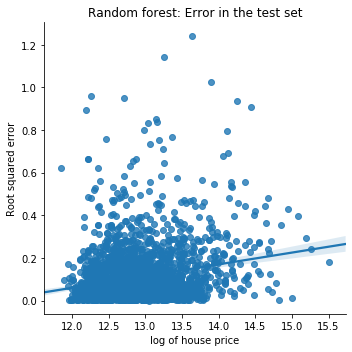

In [19]:

rse = np.sqrt((y_pred - y_test)**2)

rse_plot("Random forest: Error in the test set")


Next step is gradient boosting

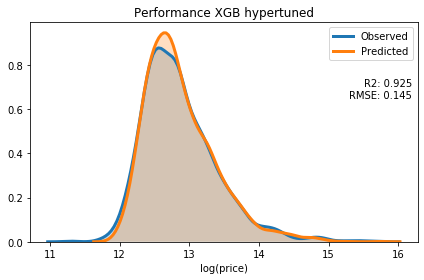

Tuned best parameters: {'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 11, 'xgb__n_estimators': 2000}


In [20]:
from xgboost import XGBRegressor

steps_xgb = [('preprocessor', preprocessor),
            ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))]

pipeline_xgb = Pipeline(steps_xgb)

params_xgb = {'xgb__n_estimators': [900,1300,1500,1700,2000],
              'xgb__max_depth': [3,5,7,9,11],
              'xgb__learning_rate': [0.01,0.1,0.3],
              'xgb__gamma': [0.0, 0.2, 0.4],
              'xgb__colsample_bytree': [0.3,0.5,0.7,1]}

grid_xgb = GridSearchCV(estimator=pipeline_xgb,
                       param_grid=params_xgb,
                       scoring='r2',
                       cv=3,
                       n_jobs=-1)

grid_xgb.fit(X_train, y_train)

best_model = grid_xgb.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_pred,y_test))

densplot('Performance XGB hypertuned', 16.2, 0.65)    
print("Tuned best parameters: {}".format(grid_xgb.best_params_))

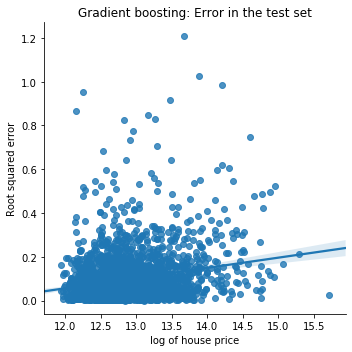

In [21]:

rse = np.sqrt((y_pred - y_test)**2)

rse_plot("Gradient boosting: Error in the test set")


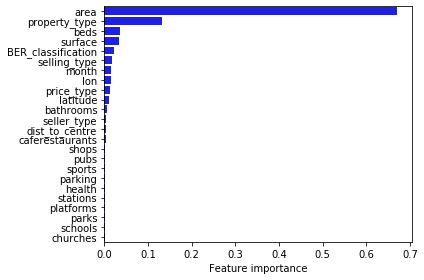

In [22]:
categorical_transformer.fit_transform(X_train[categorical_features])
catnames_array = categorical_transformer.named_steps['onehot'].get_feature_names().tolist()

catnames = []
for i in catnames_array:
    catnames.append(i)
names = numeric_features + catnames

importances_gb = pd.DataFrame(best_model.named_steps['xgb'].feature_importances_, index = names)
importances_gb['var'] = importances_gb.index.str[:3]
importances_gb.loc[0:15,'var'] = importances_gb.index[0:15]
importances_gb.loc[importances_gb['var'].str.contains('x0_'), 'var'] = 'area'
importances_gb.loc[importances_gb['var'].str.contains('x1_'), 'var'] = 'property_type'
importances_gb.loc[importances_gb['var'].str.contains('x2_'), 'var'] = 'BER_classification'
importances_gb.loc[importances_gb['var'].str.contains('x3_'), 'var'] = 'seller_type'
importances_gb.loc[importances_gb['var'].str.contains('x4_'), 'var'] = 'selling_type'
importances_gb.loc[importances_gb['var'].str.contains('x5_'), 'var'] = 'price_type'
importances_gb.loc[importances_gb['var'].str.contains('x6_'), 'var'] = 'month'
importances_gb.loc[importances_gb['var'].str.contains('x7_'), 'var'] = 'parking'

df = importances_gb.groupby('var').sum().sort_values(by=0, ascending=False)
df['var'] = df.index

sns.barplot(x=0, y='var', data=df, color='b')
plt.xlabel("Feature importance")
plt.ylabel(None)
plt.tight_layout()
plt.rcParams['figure.figsize'] = [5, 10]
plt.show()
